In [16]:
from datetime import date, timedelta

model_15mins_features = ['DPO_20', 'THERMO_20_2_0.5', 'CFO_9', 'TRUERANGE_1', 'PDIST', 'BBB_5_2.0', 'RVI_14', 'SLOPE_1', 'BULLP_13', 'BOP']

# Get today's date
today = date.today()
# Calculate start date 14 days ago
start_date = today - timedelta(days=14)
# Calculate end date 1 days ago
end_date = today - timedelta(days=1)

In [1]:
print("hi")

hi


In [3]:
import joblib

models_15 = joblib.load("models_15mins.joblib")
models_15

{'EURUSD=X': <lightgbm.sklearn.LGBMRegressor at 0x1d15b65ad50>,
 'JPY=X': <lightgbm.sklearn.LGBMRegressor at 0x1d17a856810>,
 'GBPUSD=X': <lightgbm.sklearn.LGBMRegressor at 0x1d17a856c10>,
 'AUDUSD=X': <lightgbm.sklearn.LGBMRegressor at 0x1d17a8567d0>,
 'NZDUSD=X': <lightgbm.sklearn.LGBMRegressor at 0x1d17a8574d0>,
 'HKD=X': <lightgbm.sklearn.LGBMRegressor at 0x1d17a857950>,
 'SGD=X': <lightgbm.sklearn.LGBMRegressor at 0x1d17a857dd0>,
 'MXN=X': <lightgbm.sklearn.LGBMRegressor at 0x1d17a884290>,
 'THB=X': <lightgbm.sklearn.LGBMRegressor at 0x1d17a884710>,
 'ZAR=X': <lightgbm.sklearn.LGBMRegressor at 0x1d17a884b90>,
 'RUB=X': <lightgbm.sklearn.LGBMRegressor at 0x1d17a885010>}

In [17]:
# symbols = ["EURUSD=X", "JPY=X", "GBPUSD=X", "AUDUSD=X", "NZDUSD=X","CNY=X","HKD=X","SGD=X","INR=X","MXN=X","PHP=X","IDR=X","THB=X", "MYR=X","ZAR=X","RUB=X"]
# Drop CNY=X, INR=X, PHP=X, IDR=X, MYR=X
#   - they have very irregular time intervals of non 15 mins interval
#   - model will not be able to learn well
symbols = list(models_15.keys())
symbols

['EURUSD=X',
 'JPY=X',
 'GBPUSD=X',
 'AUDUSD=X',
 'NZDUSD=X',
 'HKD=X',
 'SGD=X',
 'MXN=X',
 'THB=X',
 'ZAR=X',
 'RUB=X']

In [29]:
import pandas_ta
from pandas_ta.volatility import thermo, true_range, pdist, bbands, rvi
import pandas as pd

def get_top10_features(open, high, low, close):
    # top 10 features 'DPO_20', 'THERMO_20_2_0.5', 'CFO_9', 'TRUERANGE_1', 'PDIST', 'BBB_5_2.0', 'RVI_14', 'SLOPE_1', 'BULLP_13', 'BOP'
    dpo_df = pandas_ta.trend.dpo(close)
    thermo_df = thermo(high, low)
    cfo_df = pandas_ta.momentum.cfo(close)
    truerange_df = true_range(high, low, close)
    pdist_df = pdist(open, high, low, close)
    bbands_df = bbands(close)
    #cci_df = pandas_ta.momentum.cci(high, low, close)
    rvi_df = rvi(close, high, low)
    slope_df = pandas_ta.momentum.slope(close)
    eri_df = pandas_ta.momentum.eri(high, low, close)
    bop_df = pandas_ta.momentum.bop(open, high, low, close)

    combined = pd.concat([dpo_df, thermo_df, slope_df, cfo_df, truerange_df, bbands_df, rvi_df, pdist_df, eri_df, bop_df], axis=1)
    return combined[model_15mins_features].copy()

In [40]:
import yfinance as yf
from sklearn.model_selection import GridSearchCV, TimeSeriesSplit
import lightgbm as lgb
from sklearn.metrics import mean_squared_error, accuracy_score
prices = dict()

for symbol in symbols:
    # download the data for 15M
    prices[symbol] = yf.Ticker(symbol).history(start=start_date, end=end_date, interval = '15M').drop(columns=["Volume","Dividends","Stock Splits"])

    # if the symbol is "ABC=X", we need to invert the price to get the usd price per ABC currency
    # if the symbol is "ABCUSD=X", then the price is already in usd price per ABC currency
    if len(symbol) == 5:
        prices[symbol] = 1 / prices[symbol]

    data = prices[symbol]

    # compute the required indicators
    top10_df3 = get_top10_features(data["Open"], data["High"], data["Low"], data["Close"])
    data = pd.concat([data, top10_df3], axis=1)
    model_data = data[model_15mins_features]

    # make prediction for the next period price direction
    # get the currency pair's model
    model = models_15[symbol]

    # save the predicted y direction
    #   1 is positive => buy t+1, 0 is not positive => sell t+1
    y_pred = model.predict(model_data)
    data["buy_on_next_close"] = [1 if x > 0 else -1 for x in y_pred]

    # assumes we can buy at the next close
    data["buy_on_close"] = data["buy_on_next_close"].shift()

    prices[symbol] = data

AttributeError: 'super' object has no attribute 'get_params'

In [ ]:
prices["SGD=X"]

,Open,High,Low,Close,DPO_20,THERMO_20_2_0.5,CFO_9,TRUERANGE_1,PDIST,BBB_5_2.0,RVI_14,SLOPE_1,BULLP_13,BOP,buy_on_next_close,buy_on_close
Datetime,,,,,,,,,,,,,,,,
2024-03-29 00:00:00+00:00,0.740944,0.740576,0.741081,0.740905,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.076086,-1,NaN
2024-03-29 00:15:00+00:00,0.740949,0.740851,0.741015,0.740971,NaN,0.000274,NaN,0.000165,-0.000307,NaN,NaN,0.000066,NaN,-0.133105,-1,-1.0
2024-03-29 00:30:00+00:00,0.740988,0.740774,0.741004,0.740818,NaN,0.000077,NaN,0.000231,-0.000615,NaN,NaN,-0.000154,NaN,0.738035,-1,-1.0
2024-03-29 00:45:00+00:00,0.740883,0.740724,0.741136,0.740933,NaN,0.000132,NaN,0.000412,-0.000807,NaN,NaN,0.000115,NaN,-0.120006,-1,-1.0
2024-03-29 01:00:00+00:00,0.740999,0.740905,0.741026,0.740977,NaN,0.000181,NaN,0.000121,-0.000198,0.031206,NaN,0.000044,NaN,0.182125,-1,-1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-04-10 22:45:00+01:00,0.739098,0.738825,0.739208,0.738880,NaN,0.000071,0.000707,0.000382,-0.000710,0.030967,55.859163,0.000055,0.000002,0.571313,1,1.0
2024-04-10 23:00:00+01:00,0.739076,0.738552,0.739142,0.738662,NaN,0.000273,-0.020560,0.000590,-0.001397,0.053993,50.407350,-0.000218,-0.000248,0.703872,-1,1.0
2024-04-10 23:15:00+01:00,0.738727,0.738662,0.738863,0.738798,NaN,0.000279,-0.001049,0.000202,-0.000409,0.039651,54.055978,0.000136,-0.000138,-0.351482,1,-1.0


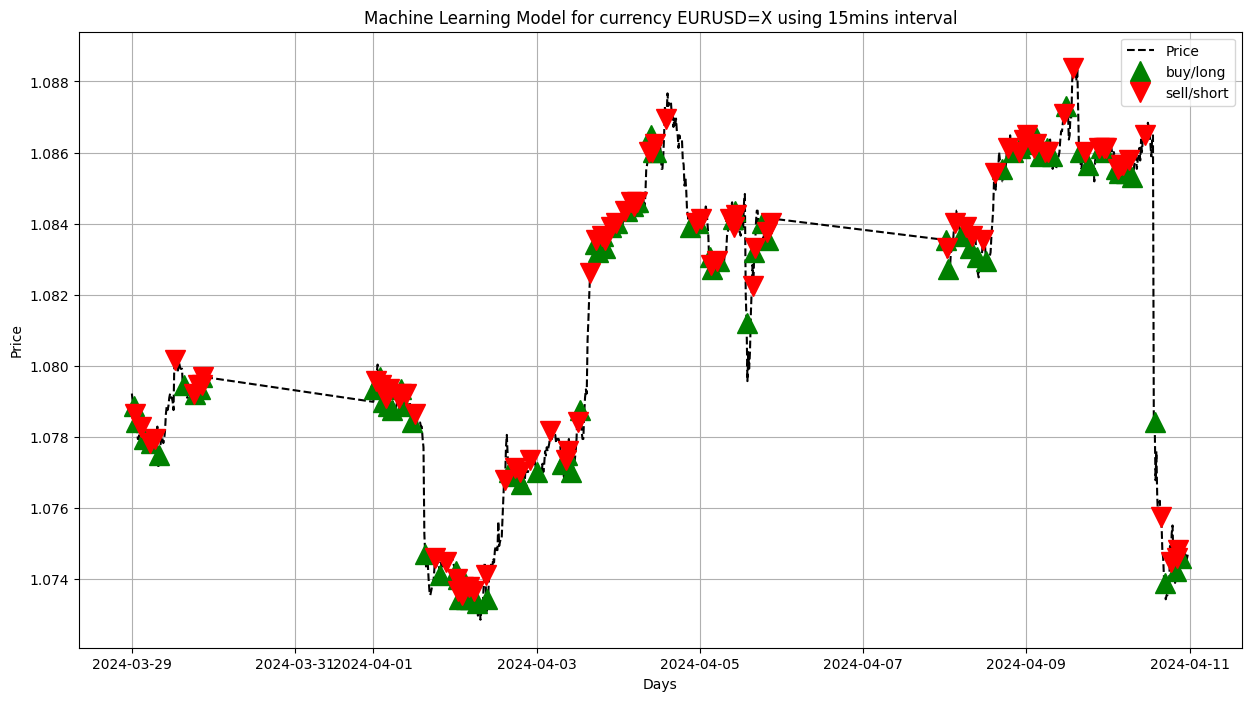

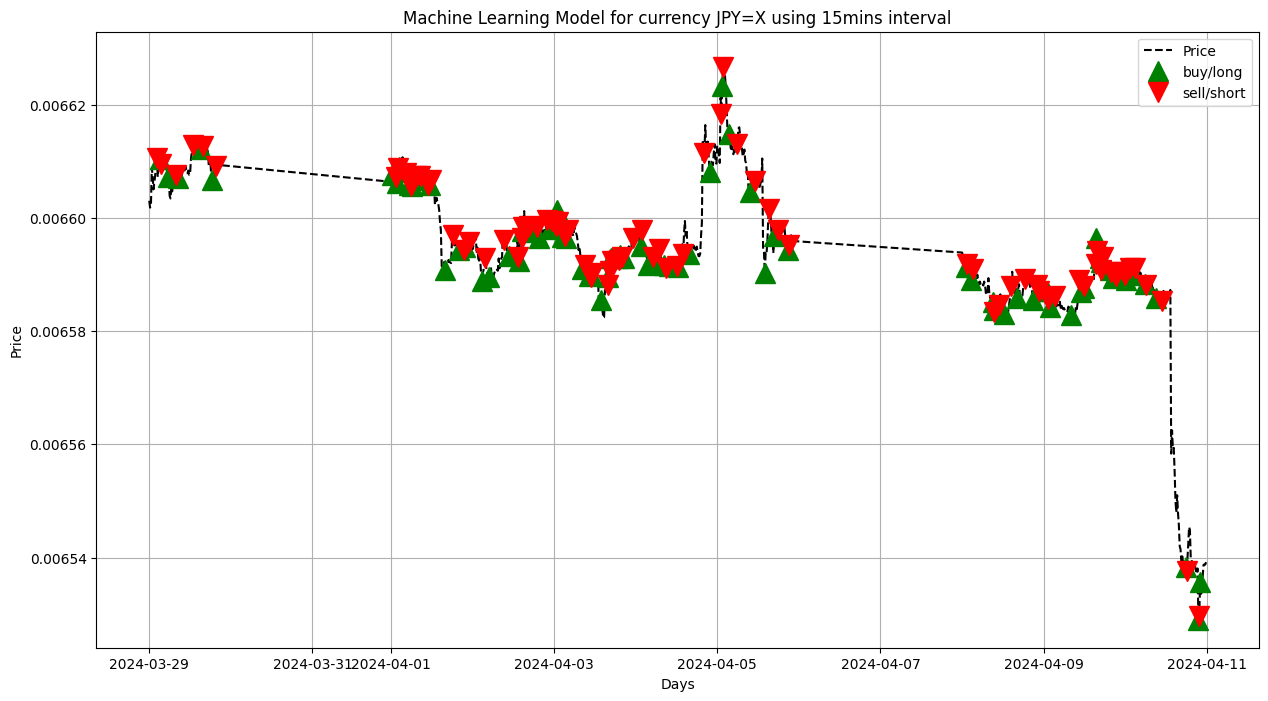

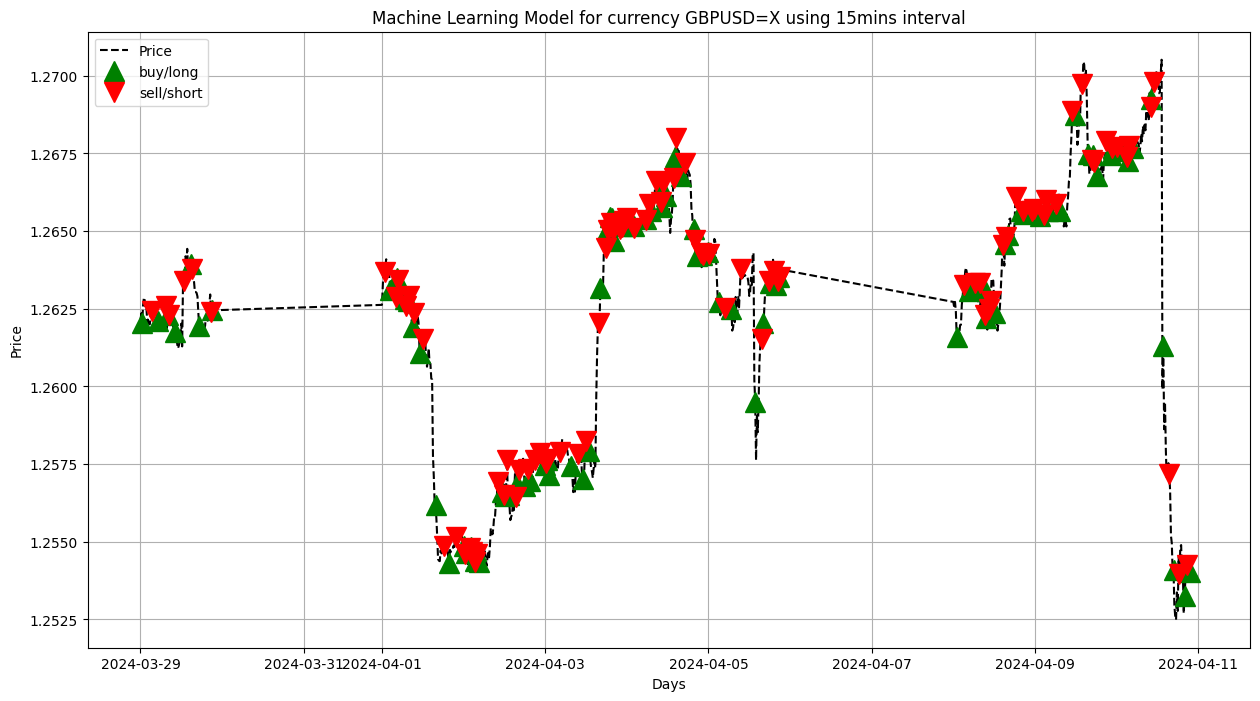

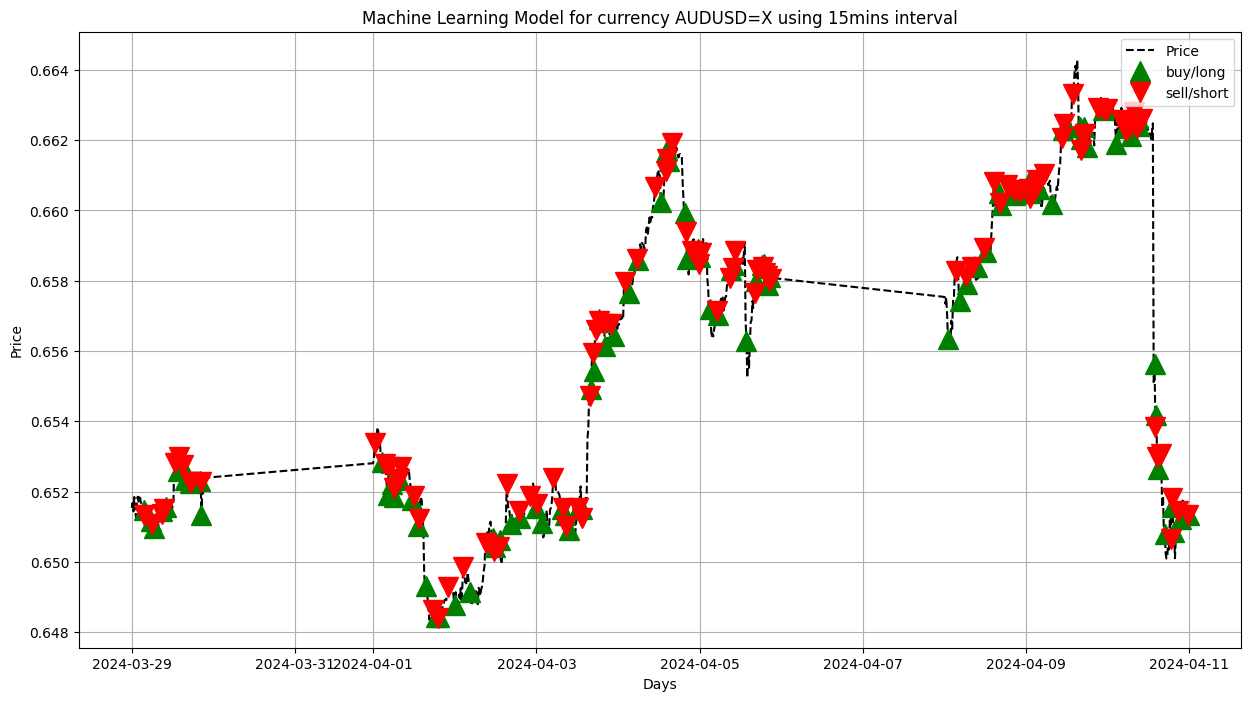

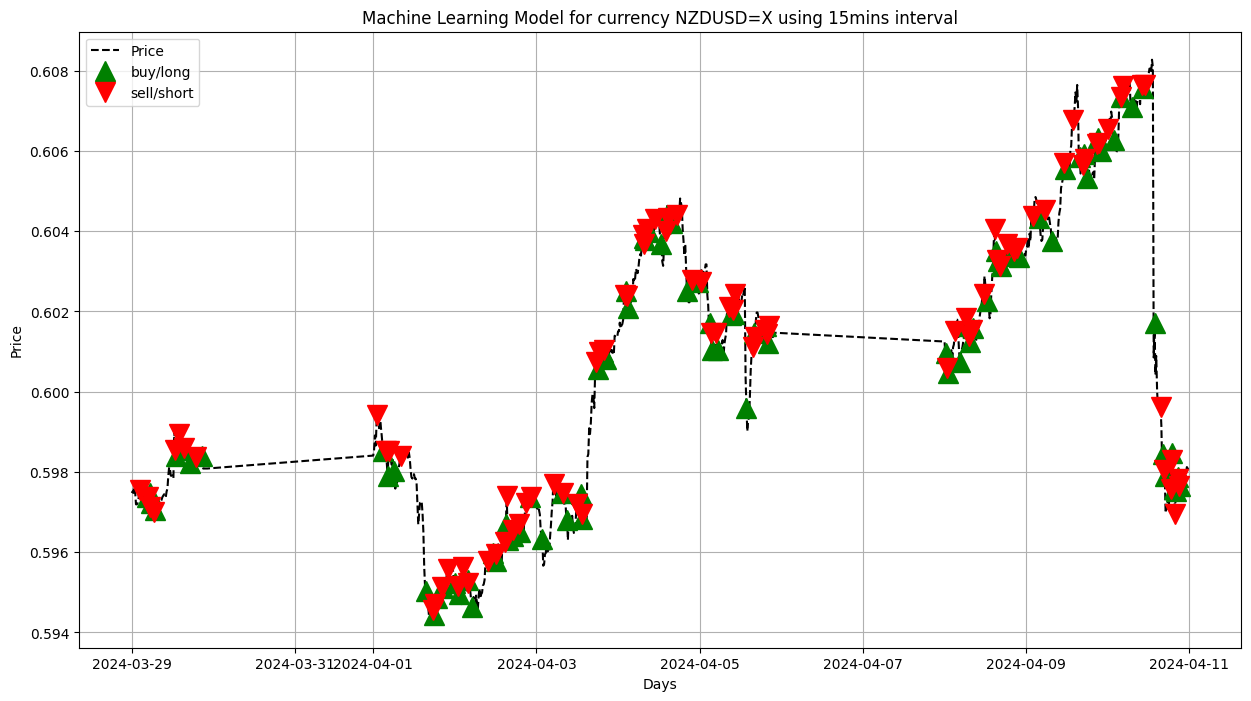

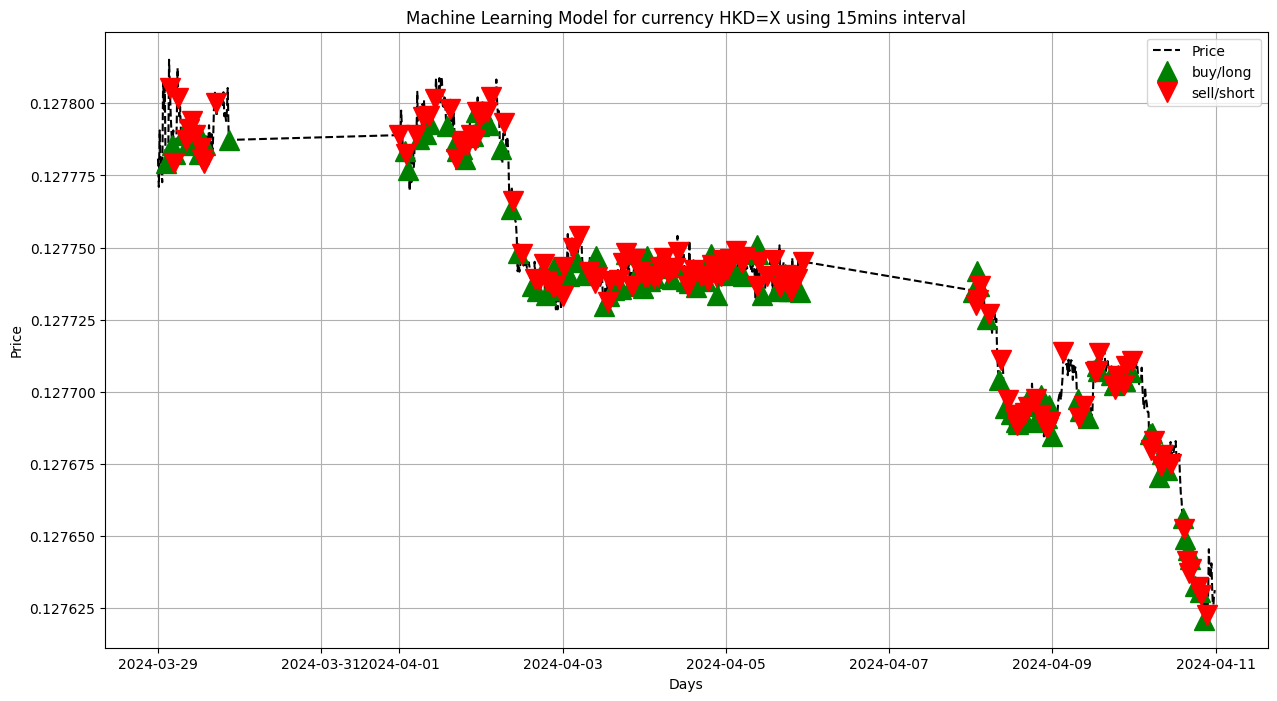

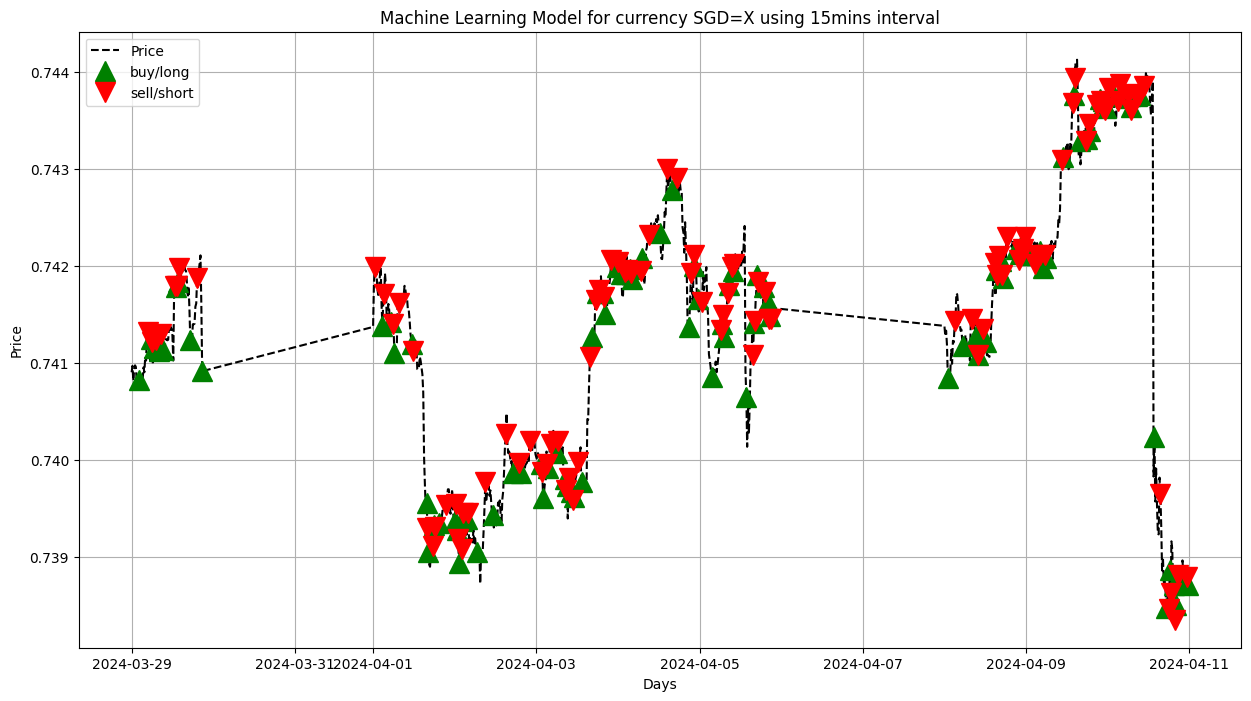

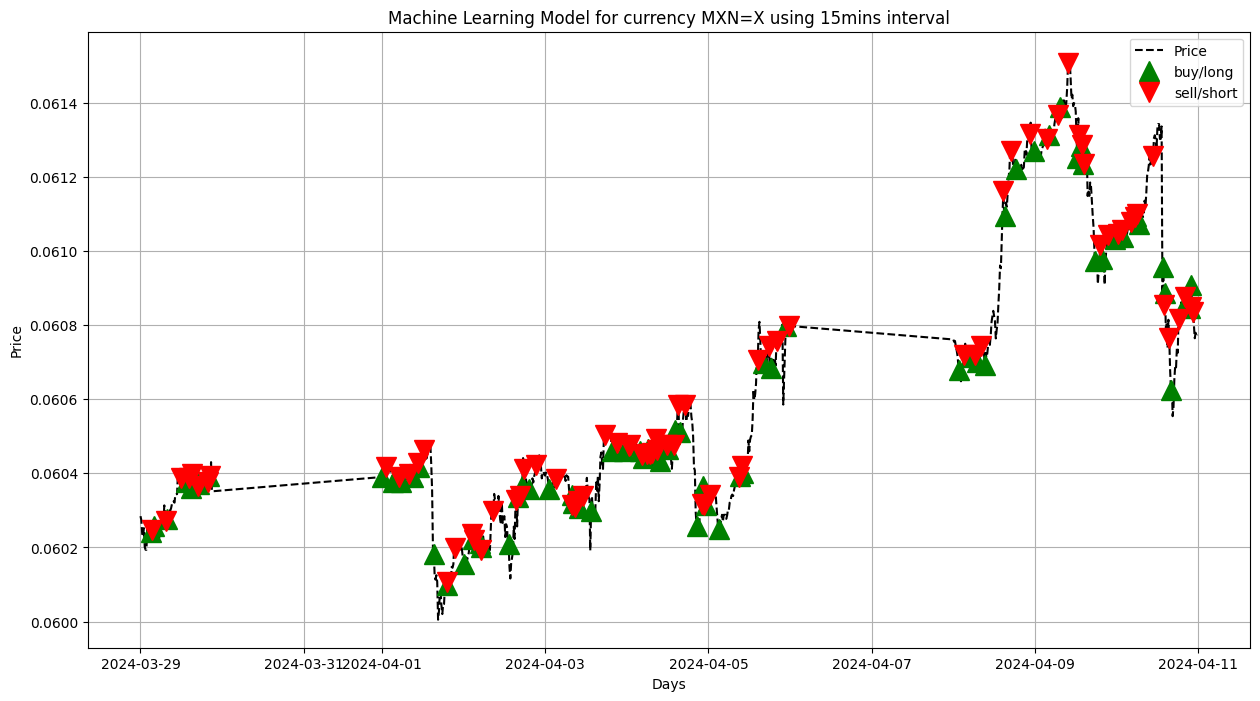

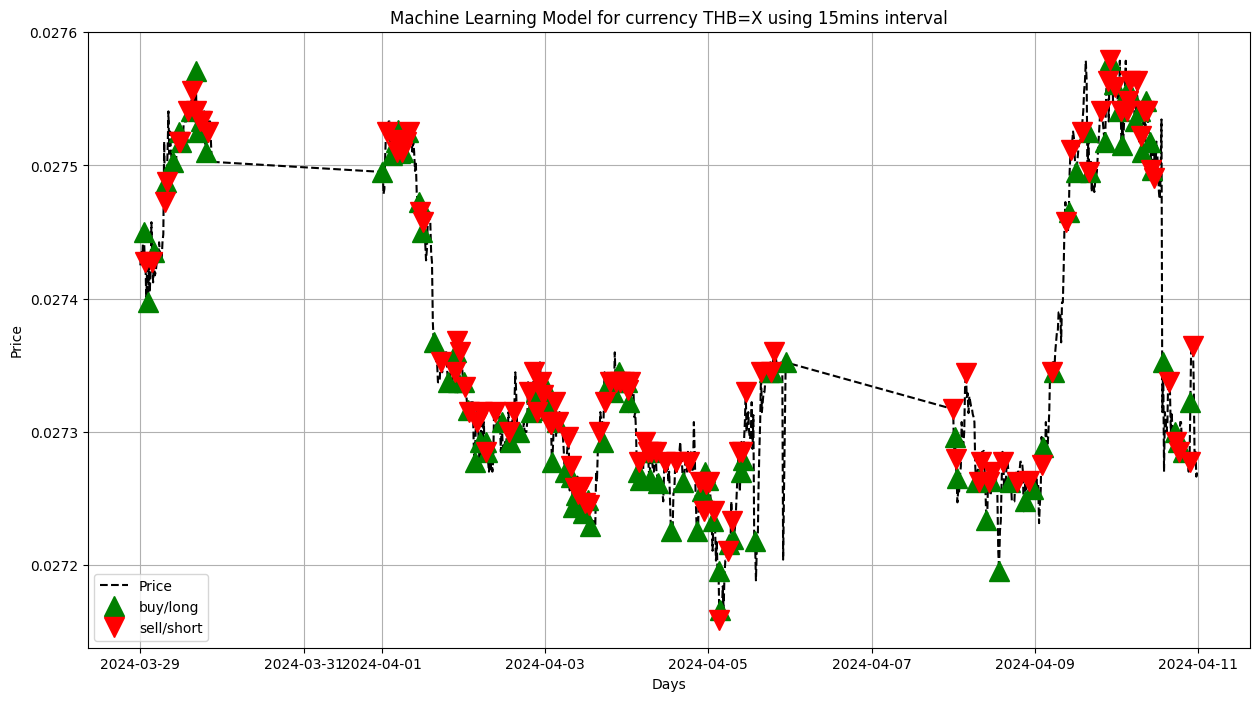

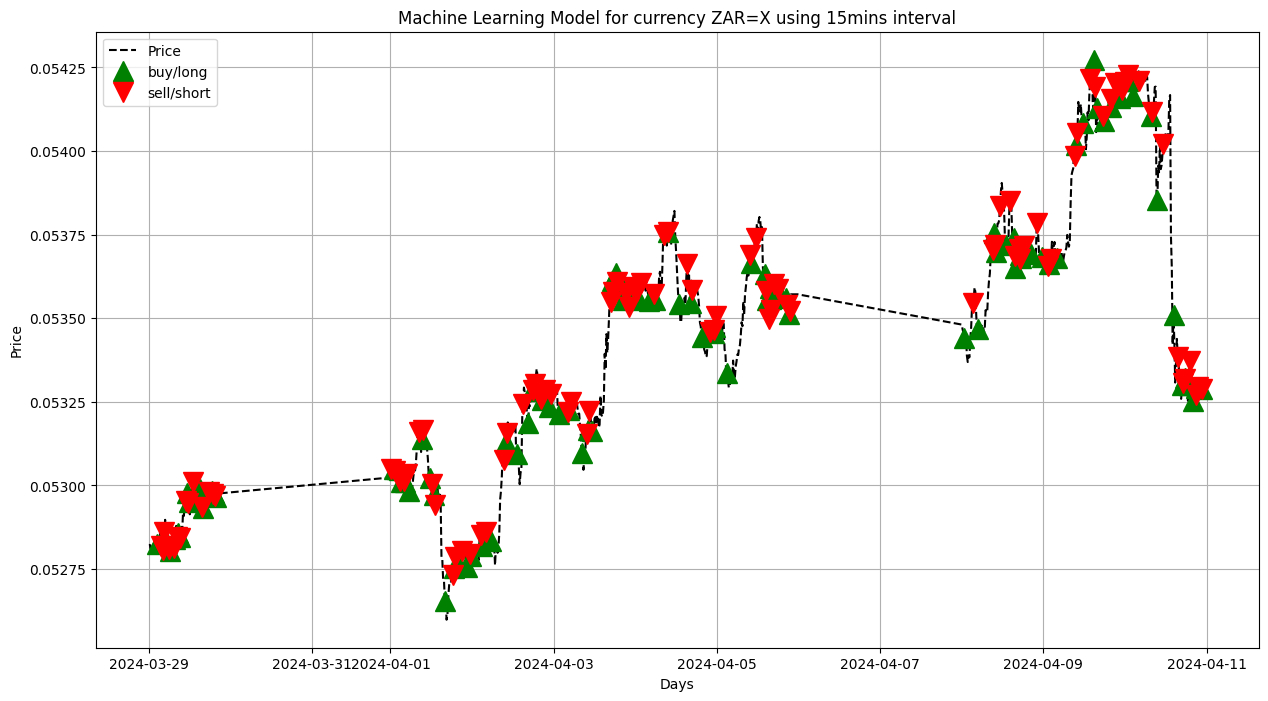

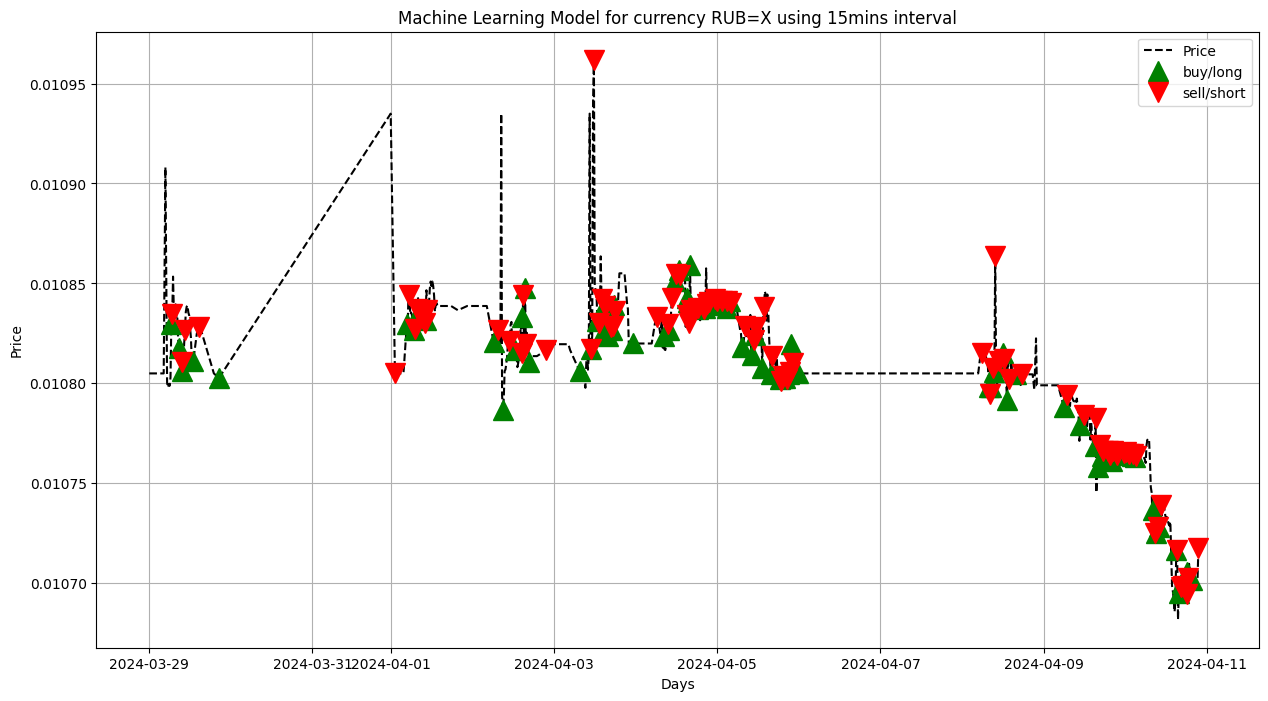

In [ ]:
import matplotlib.pyplot as plt

for symbol in symbols:
        data = prices[symbol]

        # assumes we buy at next close
        signal = data["buy_on_close"].diff()

        plt.figure(figsize=(15, 8))
        plt.plot(data["Close"] ,color='black', label='Price', linestyle='dashed')
        #plt.plot(data["DPO_20"], color='b', label='Detrend Price Oscillator')

        # plot ‘buy’ signals. buy signal == 2
        plt.plot(signal[signal == 2].index,
                data["Close"][signal == 2],
                '^', markersize = 15, color = 'g', label = 'buy/long')

        # plot ‘sell’ signals. sell signal == -2
        plt.plot(signal[signal == -2].index,
                data["Close"][signal == -2],
                'v', markersize = 15, color = 'r', label = 'sell/short')

        plt.xlabel("Days")
        plt.ylabel("Price")
        plt.title("Machine Learning Model for currency {} using 15mins interval".format(symbol))
        plt.legend()
        plt.grid()
        plt.show()